# t-SNE

*Author: Bjarne Hiller*

In this notebook, we will implement t-SNE (t-distributed stochastic neighbor embedding). t-SNE is a *nonlinear* dimensionality reduction algorithm developed by Laurens van der Maaten and Geoffrey Hinton in 2008 (see [original paper](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)).

(100, 20)


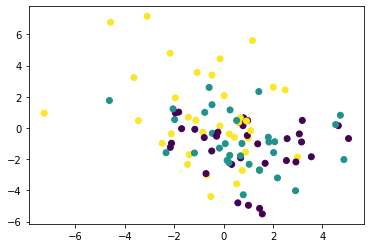

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19)

# first, let's create a highdimensional dataset

from sklearn.datasets import make_classification, make_blobs

X, y = make_classification(n_samples=100, n_classes=3, n_informative=15, n_clusters_per_class=1)
#X, y = make_blobs(n_samples=100, centers=3, n_features=10)

print(X.shape)
plt.scatter(X[:,0], X[:,1], c=y)

## Similarities

- want to compute a map from the high-dimensional space into visualizable 2 or 3 dimensions
- want to keep structure of the data: similar points should be close together, dissimilar points should be far away
- need methods to compute the distances between points

In [2]:
import numpy as np
from numpy.linalg import norm

def pairdiff(X):
    """Returns a matrix M[i,j] -> x_i - x_j"""
    MX = np.repeat(X[:,np.newaxis,:], len(X), axis=1) # repeat elements on columns
    MXT = MX.transpose(1, 0, 2) # (n,n,2), idx on second
    return MX - MXT

def distances(X):
    """Returns a matrix M[i,j] -> euclidean distance between x_i and x_j"""
    return norm(pairdiff(X), axis=2)

# Probability Distributions

- Based on the distances, we can compute similarity scores
- similarity of two points should be higher, if distance is small, and vice versa
- can represent similarity scores as probability distributions: "How likely is it, that point i will choose point j as its neighbor?"

Conditional Gaussian Distribution for higher dimensional space:
$$
p_{j|i} = \frac{\exp(-||x_i - x_j||^2 / 2 \sigma_i^2)}{\sum_{k\neq i} \exp(-||x_i - x_k||^2 / 2 \sigma_i^2)}
$$

- however, conditional probability distribution is not symmetric
- if point i is to 99% likely to choose j as neighbor, then j could choose i only with 1% probability
- this doesn't make sense: the distribution should be symmetric to reflect similarities
- also, this simplifies computation later on

Construct symmetric joint probability distribution:
$$
p_{ij} = \frac{p_{i|j} + p_{j|i}}{2n}
$$

- in normal SNE, we would choose the same method to construct the distribution for the low dimensional map
- however, this often leads to the *crowding problem*
- small forces of distant points add up to drag all points to the center of the map
- t-SNE uses the student t-distribution for the lower dimensional map
- t-distribution is more heavy-tailed than normal distribution
- this ensures, that for distant points, $q_{ij}$ (map similarity) will be slightly greater than $p_{ij}$ (space similarity)
- adds a small repulsive force, to keep dissimilar points away from each other

t-Distribution for lower dimensional map:
$$
q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l} (1 + ||y_k - y_l||^2)^{-1}}
$$

In [3]:
def cprob(X, sigma):
    """Returns a Matrix P[i,j] -> p(i|j), the probability that point j would choose point i as neighbor."""
    D = distances(X)
    # divide each column by corresponding sigma
    E = np.exp(- np.power(D,2) / (2 * np.power(sigma, 2)))
    # mask out distances to self, which are 1 after exp(0)
    np.fill_diagonal(E, 0)
    # normalize each column
    return E / E.sum(0)

def symmetrize(P):
    """Computes a symmetric joint probability distribution."""
    return (P + P.T) / (2 * len(P))

def tprob(Y):
    """Returns a symmetric Matrix P[i,j] -> similarity scores for the low-dimensional map."""
    D = distances(Y)
    E = 1 / (1 + np.power(D, 2))
    np.fill_diagonal(E, 0) # mask out distances to self
    Q = E / E.sum()
    return Q

## Gradient

- now, we can compare the distributions of the lower-dimensional map and the higher-dimensional space
- if the map is any good, the probability distributions should be similar
- to compare probability distributions, we can use the *Kullback-Leibler-Divergence*

$$
KL(P||Q) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

- now we can just use gradient descent to minimize the Kullback-Leibler-Divergence
- the gradient is surprisingly simple and is given by:

$$
\frac{\partial C}{\partial y_i} = 4 \sum_j \frac{(p_{ij} - q_{ij}) (y_i - y_j)}{(1+||y_i - y_j||^2)}
$$

In [4]:
def gradients(P, Q, Y):
    # returns an array g -> (n,2) with gradients for all y_i
    # P, Q -> (i,j), Y -> (n,2)
    dy = pairdiff(Y).transpose(2,0,1) # transpose for broadcasting
    D = distances(Y)
    a = (P - Q) * dy
    b = 1 + np.power(D, 2)
    return 4 * (a / b).sum(2).T # transpose back to (n,2)

# Shannon Entropy and Perplexity

- but how to find the parameter $\sigma$ for computing the probability distribution in the high-dimensional space?
- with increasing $\sigma$, the more probability gets assigned to distant points
- therefore configuring $\sigma$ allows to set focus on local or global structure
- probably requires different $\sigma$ for each point, since the point density might vary
- however, want to provide some option to the user, which is more interpretable
- perplexity is based on shannon entropy, can be interpreted as number of effective neighbors for each point
- perplexity increases monotonically with variance $\sigma^2$

Shannon Entropy:
$$
H(P_i) = - \sum_j p_{j|i} \log_2 p_{j|i}
$$

Perplexity:
$$
Perp(P_i) = 2^{H(P_i)}
$$

In [5]:
def entropy(P_ij):
    """Computes the Shanon Entropy for a given matrix of conditional probability distributions."""
    # P_ji contains 0 on the main diagonal, would become -inf after log
    # since we multiply with the probability of 0 anyway, we can mask 0 values out
    P_masked = np.where(P_ij == 0, 1, P_ij)
    # np.fill_diagonal(P_masked, 1)
    # returns the mean number of bits required to encode a random neighbor
    return -(P_ij * np.log2(P_masked)).sum(0)

def perp(P_ij):
    """Computes the Perplexity for a given conditional probability distribution."""
    return np.power(2, entropy(P_ij))

def find_sigma(X, target_perp, max_iter=50, tol=1e-4):
    """Performs a binary search to find the sigmas that fit the given perplexity."""
    sigma = np.ones(len(X))
    sigma_min = np.zeros(len(X))
    sigma_max = np.ones(len(X)) * np.inf
    for i in range(max_iter):
        P_ij = cprob(X, sigma)
        d = perp(P_ij) - target_perp
        # if perplexity is lower than target, increase sigma to increase perplexity
        sigma_min = np.where(d < 0, sigma, sigma_min)
        sigma = np.where((d < 0) & np.isinf(sigma_max), sigma * 2, sigma)
        sigma = np.where((d < 0) & (~np.isinf(sigma_max)), (sigma + sigma_max) / 2, sigma)
        # if perplexity is greater than target, decrease sigma to decrease perplexity
        sigma_max = np.where(d > 0, sigma, sigma_max)
        sigma = np.where(d > 0, (sigma_min + sigma) / 2, sigma)
    return sigma

## Welcome to t-SNE-land!

In [6]:
from tqdm.notebook import trange

def tsne(X, perplexity=30, n_iter=1000, lr=1):
    # initialize an array of random 2d points sampled from a gaussian
    # paper recommends starting with a small scale, so clusters can easily pass through another
    Y = np.random.normal(size=(len(X), 2), scale=1e-4)
    # find the best variance sigma for the given perplexity
    sigma = find_sigma(X, perplexity)
    # define the conditional probability distribution on the high-dimensional space
    P_ij = cprob(X, sigma)
    # use the symmetric joint probability distribution for simpler gradients
    P = symmetrize(P_ij)
    for i in trange(n_iter):
        # compute the probability distribution on the low-dimensional map
        Q = tprob(Y)
        # perform gradient descent
        Y -= lr * gradients(P, Q, Y)
    return Y

In [7]:
X2d = tsne(X, perplexity=5, lr=100, n_iter=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

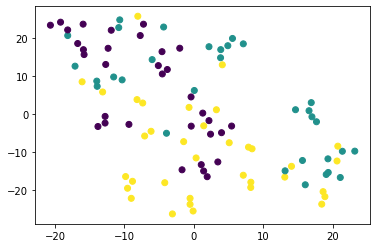

In [8]:
plt.scatter(X2d[:,0], X2d[:,1], c=y)

## Comparison with sklearn

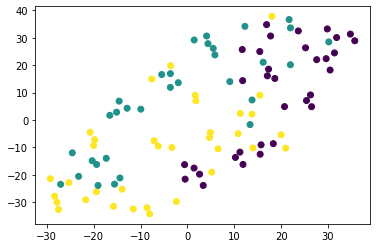

In [9]:
from sklearn.manifold import TSNE

X2d = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(X)
plt.scatter(X2d[:,0], X2d[:,1], c=y)